# Identifying Fst outliers in _Varroa_ populations
VCF has been filtered to remove rare sites (MAF<0.1), and the OutFlank analyses have been pre-computed inthe Snakefile and saved into corresponding RDS objects.

In [65]:
library(tidyverse)
library(OutFLANK)
library(ggrepel) # for text labels
library(pcadapt)
library(data.table) #faster loading of huge data files

In [2]:
majorLG <- c("BEIS01000001.1", "BEIS01000002.1", "BEIS01000003.1", "BEIS01000004.1", "BEIS01000005.1", "BEIS01000006.1", "BEIS01000007.1")

We may want to plot only the major contigs.
## PCAadapt


In [3]:
metadata <- read.table("../ref/varroa.txt", header = T, sep = "\t")
head(metadata)
vd_raw <- fread("../data/R/vd.012", drop = 1)
dim(vd_raw)
vj_raw <- fread("../data/R/vj.012", drop = 1)
dim(vj_raw)

id,collectedHost,species,fedHost,ceranaReads,melliferaReads,year,country
VD149,cerana,VD,cerana,1773,76,1996,Vietnam
VD150_2,mellifera,VD,mellifera,26,218,1996,Vietnam
VD153_2,mellifera,VD,mellifera,0,5824,1996,South Korea
VD159_1,mellifera,VD,mellifera,14,5707,1996,South Korea
VD212,cerana,VD,cerana,56,0,1996,South Korea
VD474_1,mellifera,VD,mellifera,52,648,1998,Vietnam


Read 19 rows and 988225 (of 988226) columns from 0.035 GB file in 00:00:06


[1]     19 988225

[1]     25 588275

### _Varroa jacobsoni_

In [4]:
genotype_file_vj <- tempfile()
fwrite(x = transpose(vj_raw), 
            file = genotype_file_vj, 
            sep = " ", 
            col.names = FALSE, 
            row.names = FALSE)
print("wrote temporary table")
K<-10
x_vj <- pcadapt(genotype_file_vj, K = K)

[1] "wrote temporary table"
Reading file /scratch/RtmpwY07Ak/file56fe7850232b...
Number of SNPs: 588275
Number of individuals: 25
Number of SNPs with minor allele frequency lower than 0.05 ignored: 355


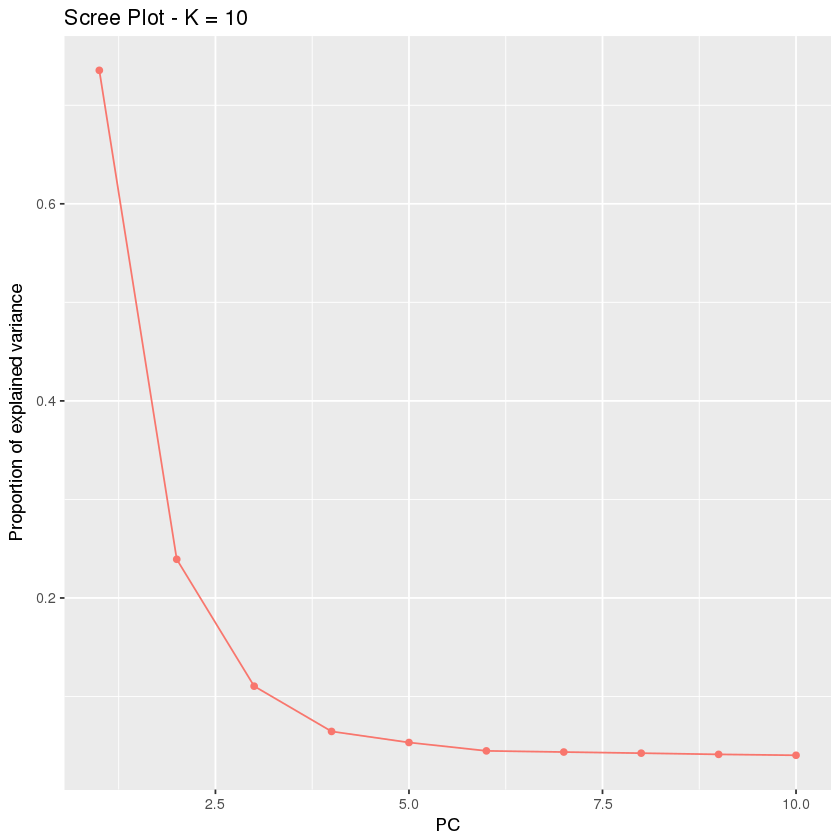

In [5]:
plot(x_vj, option = "screeplot")
#plot(x, option = "scores", pop = sel[, 1]) # how populations are shared among the 19 groups

Joining, by = "id"
Warning message:
“Column `id` joining factors with different levels, coercing to character vector”

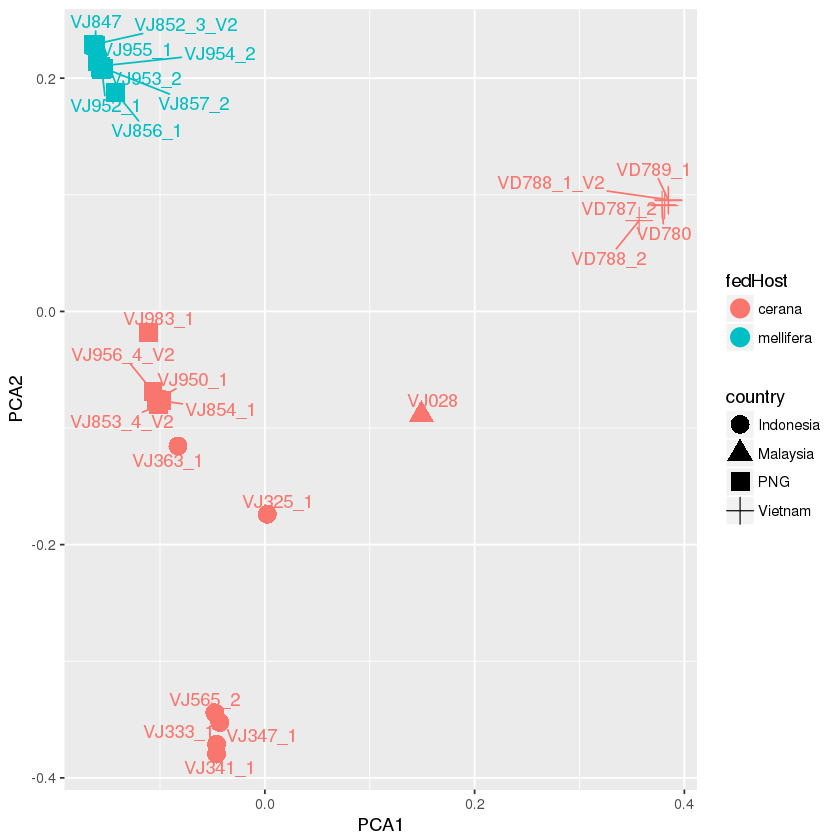

In [6]:
as.data.frame(x_vj$scores[,1:2]) %>% rename(PCA1 = V1, PCA2 = V2) %>% 
mutate(id = read.table("../data/R/vj.012.indv")[,1] ) %>%
inner_join(metadata) %>%
ggplot(aes(PCA1,PCA2, color = fedHost, shape = country)) + geom_point(size=5) + geom_text_repel(aes(label = id))


Choosing K=3 via Cattel's rule

In [7]:
K <- 3
x_vj <- pcadapt(genotype_file_vj, K = K)

Reading file /scratch/RtmpwY07Ak/file56fe7850232b...
Number of SNPs: 588275
Number of individuals: 25
Number of SNPs with minor allele frequency lower than 0.05 ignored: 355


Warning message:
“Removed 2755 rows containing non-finite values (stat_bin).”

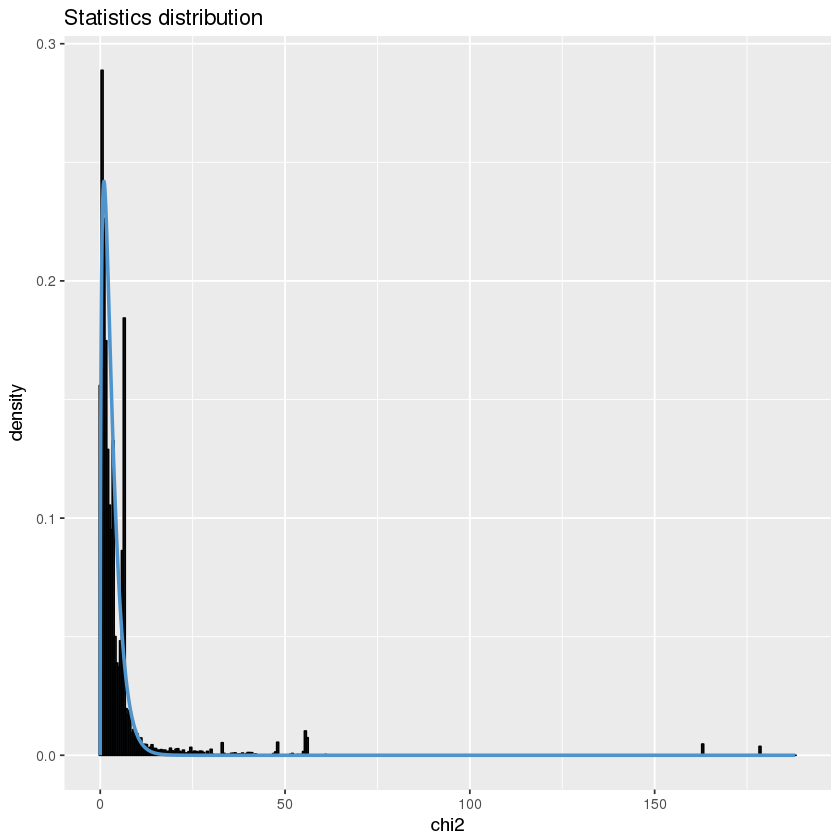

In [8]:
plot(x_vj, option = "stat.distribution") # Distribution of Mahalanobis distances.

In [9]:
qval_vj <- qvalue(x_vj$pvalues)$qvalues
alpha <- 0.05
outliers_pcadapt_vj <- which(qval_vj < alpha)
length(outliers_pcadapt_vj)

[1] 34397

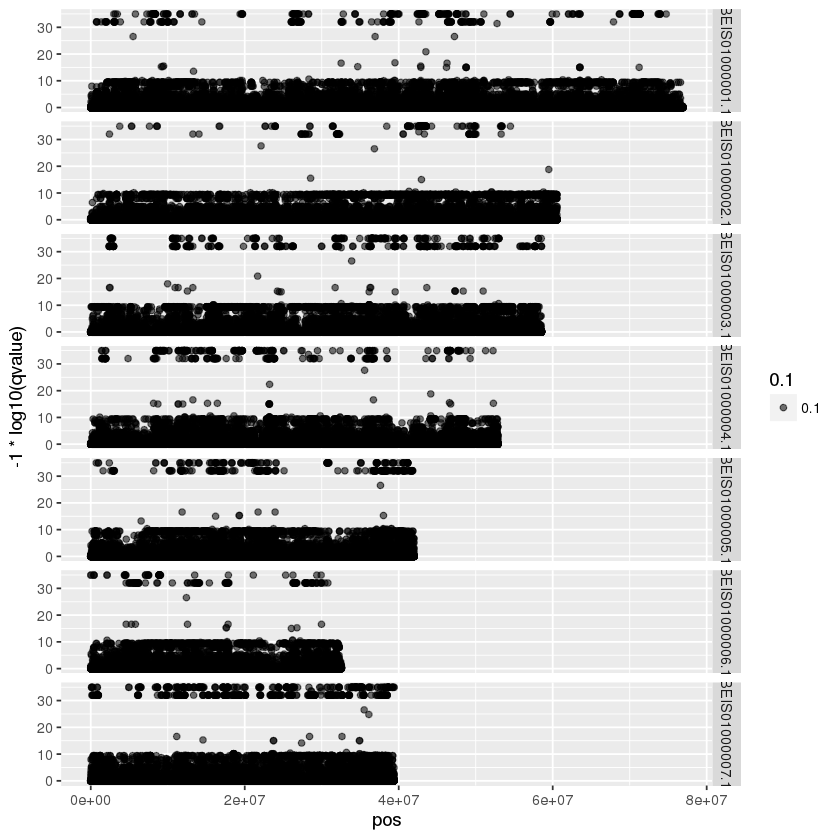

In [10]:
vj.pcadapt <- read.table("../data/R/vj.012.pos",header=F) %>% rename(chrom = V1, pos = V2) %>%
mutate(siteId = paste(chrom, pos, sep="_")) %>%
mutate(qvalue = qval_vj) %>% na.omit()
vj.pcadapt %>% filter(chrom %in% majorLG) %>%
ggplot(aes(pos, -1*log10(qvalue), alpha = 0.1))+facet_grid(chrom~.)+geom_point()

### _Varroa destructor_

In [11]:
genotype_file_vd <- tempfile()
fwrite(x = transpose(vd_raw), 
            file = genotype_file_vd, 
            sep = " ", 
            col.names = FALSE, 
            row.names = FALSE)
print("wrote temporary table")
K<-10
x_vd <- pcadapt(genotype_file_vd, K = K)

[1] "wrote temporary table"
Reading file /scratch/RtmpwY07Ak/file56fe73556a6b...
Number of SNPs: 988225
Number of individuals: 19
Number of SNPs with minor allele frequency lower than 0.05 ignored: 412


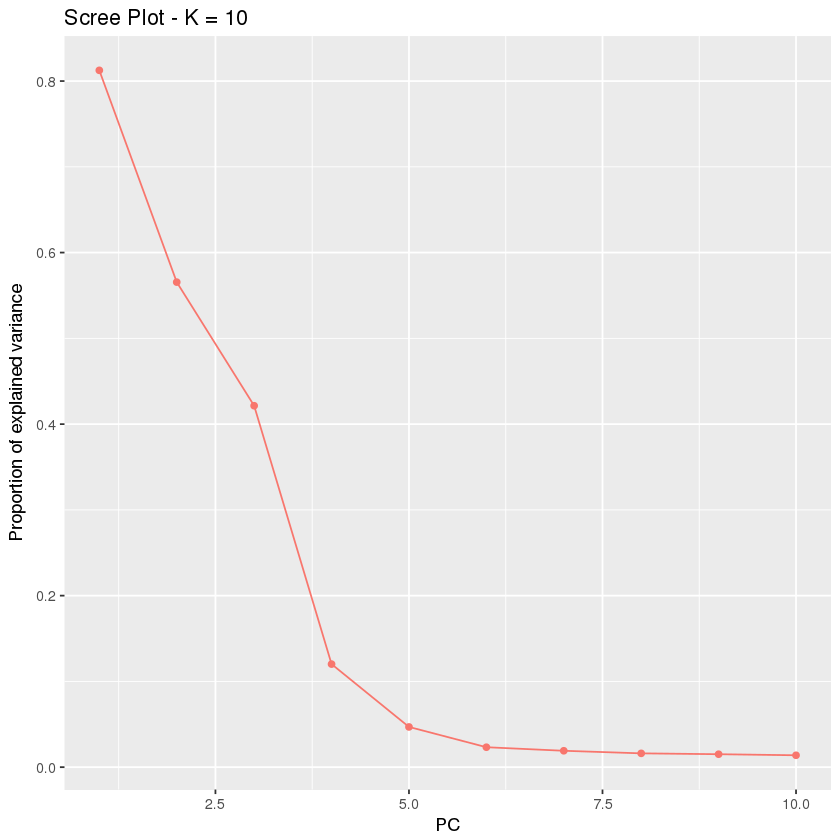

In [12]:
plot(x_vd, option = "screeplot")

Joining, by = "id"
Warning message:
“Column `id` joining factors with different levels, coercing to character vector”

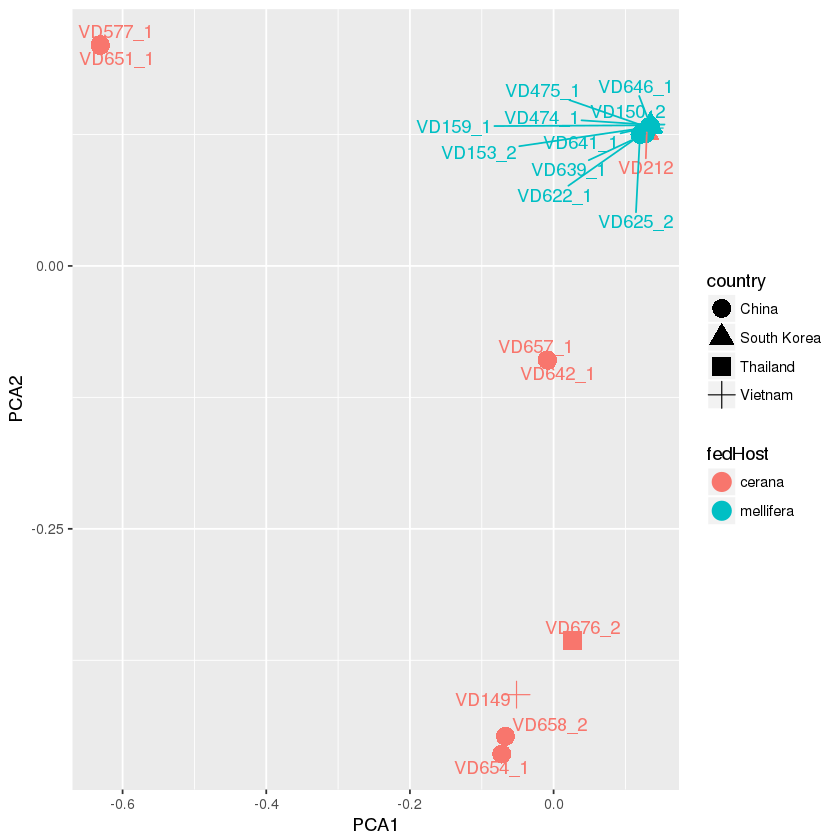

In [13]:
as.data.frame(x_vd$scores[,1:2]) %>% rename(PCA1 = V1, PCA2 = V2) %>% 
mutate(id = read.table("../data/R/vd.012.indv")[,1] ) %>%
inner_join(metadata) %>%
ggplot(aes(PCA1,PCA2, color = fedHost, shape = country)) + geom_point(size=5) + geom_text_repel(aes(label = id))

In [14]:
K <- 4
x_vd <- pcadapt(genotype_file_vd, K = K)

Reading file /scratch/RtmpwY07Ak/file56fe73556a6b...
Number of SNPs: 988225
Number of individuals: 19
Number of SNPs with minor allele frequency lower than 0.05 ignored: 412


Warning message:
“Removed 209 rows containing non-finite values (stat_bin).”

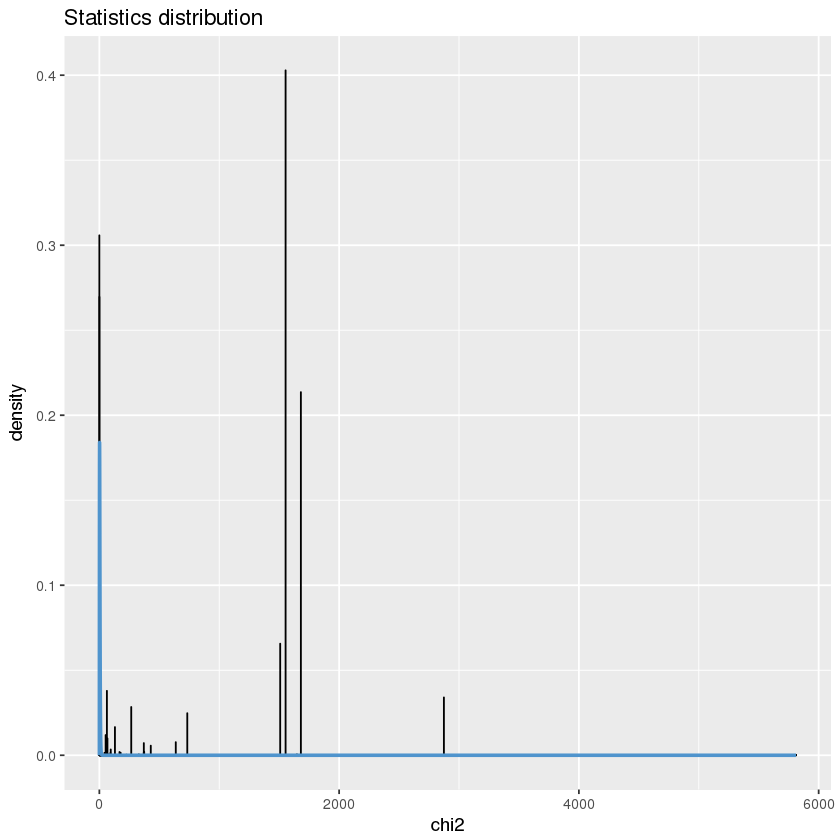

In [15]:
plot(x_vd, option = "stat.distribution") 

In [16]:
qval_vd <- qvalue(x_vd$pvalues)$qvalues
alpha <- 0.05
outliers_pcadapt_vd <- which(qval_vd < alpha)
length(outliers_pcadapt_vd)

[1] 443584

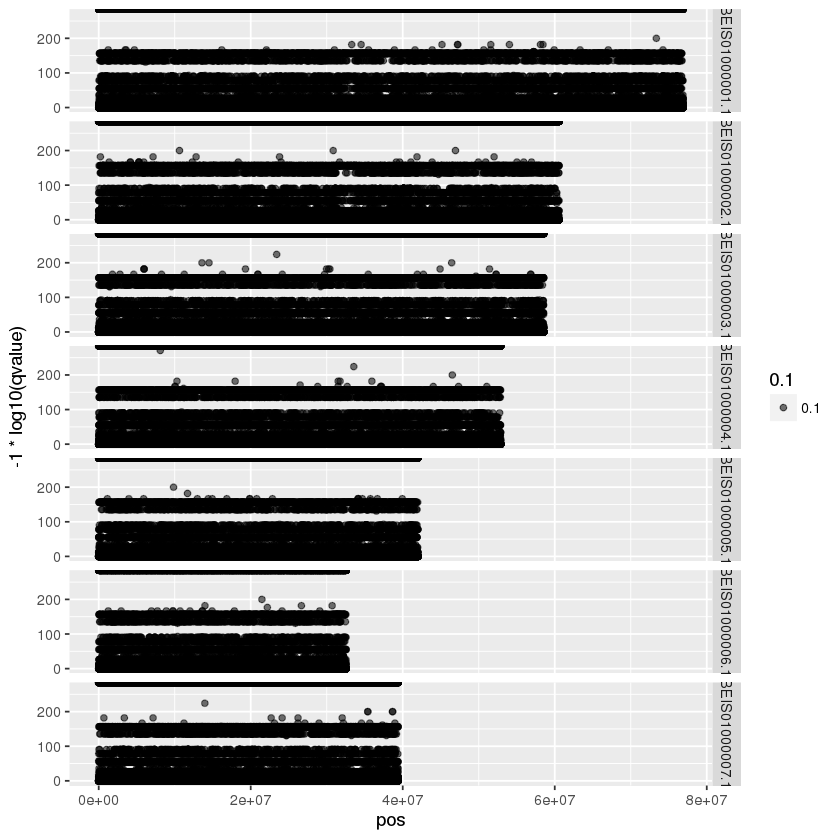

In [17]:
vd.pcadapt <- read.table("../data/R/vd.012.pos",header=F) %>% 
rename(chrom = V1, pos = V2) %>% mutate(siteId = paste(chrom, pos, sep="_")) %>%
mutate(qvalue = qval_vd) %>% na.omit() 
vd.pcadapt %>% filter(chrom %in% majorLG) %>%
ggplot(aes(pos, -1*log10(qvalue), alpha = 0.1))+facet_grid(chrom~.)+geom_point()

### Comparing _destructor_ and _jacobsoni_

In [18]:
any <- union(vd.pcadapt$siteId, vj.pcadapt$siteId)
vd.pcadapd.outlier <- filter(vd.pcadapt, qvalue < 0.05)$siteId
vj.pcadapd.outlier <- filter(vj.pcadapt, qvalue < 0.05)$siteId
both <- intersect(vd.pcadapd.outlier, vj.pcadapd.outlier )
c((n_A_B <- length(both)),
(n_C <- length(any)),
(n_A <- length(vj.pcadapd.outlier)),
(n_B <- length(vd.pcadapd.outlier)))
# https://stats.stackexchange.com/questions/267/how-do-i-calculate-if-the-degree-of-overlap-between-two-lists-is-significant
phyper(n_A_B, n_B, n_C-n_B, n_A, lower.tail = FALSE)

[1]      74 1530465   34397  443584

[1] 1

No overlap at all between Vd and Vj markers.

### _Varroa jacobsoni_

## OutFLANK

In [19]:
# list with "fst" and "of" elements
vd <- readRDS("../data/R/vd.outflank.rds")
vj <- readRDS("../data/R/vj.outflank.rds")

In [62]:
ls(vj[["fst"]])
cor.test(vj[["fst"]]$He, vj[["fst"]]$FST)

[1] "FST"            "FSTNoCorr"      "He"             "LocusName"     
[5] "meanAlleleFreq" "T1"             "T1NoCorr"       "T2"            
[9] "T2NoCorr"


	Pearson's product-moment correlation

data:  vj[["fst"]]$meanAlleleFreq and vj[["fst"]]$FST
t = -82.822, df = 585140, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1101740 -0.1051089
sample estimates:
       cor 
-0.1076422 


In [63]:
vj.of  <- OutFLANK(vj[["fst"]], NumberOfSamples=2, qthreshold = 0.05, 
                   LeftTrimFraction = 0.2, RightTrimFraction = 0.5, Hmin=0.2)
table(vj.of$results$OutlierFlag)


 FALSE 
585144 

In [50]:
#head(vd.of$results$pvalues)
ls(vd.of$results)
table(vd.of$results$pvaluesRightTail<.05)
#plot(qvalue(vd.of$results$pvalues)$qvalues,vd.of$results$qvalues)

[1] "FST"              "FSTNoCorr"        "GoodH"            "He"              
 [5] "indexOrder"       "LocusName"        "meanAlleleFreq"   "OutlierFlag"     
 [9] "pvalues"          "pvaluesRightTail" "qvalues"          "T1"              
[13] "T1NoCorr"         "T2"               "T2NoCorr"


 FALSE 
582543 

### _Varroa jacobsoni_

Warning message:
“Removed 3131 rows containing non-finite values (stat_binhex).”

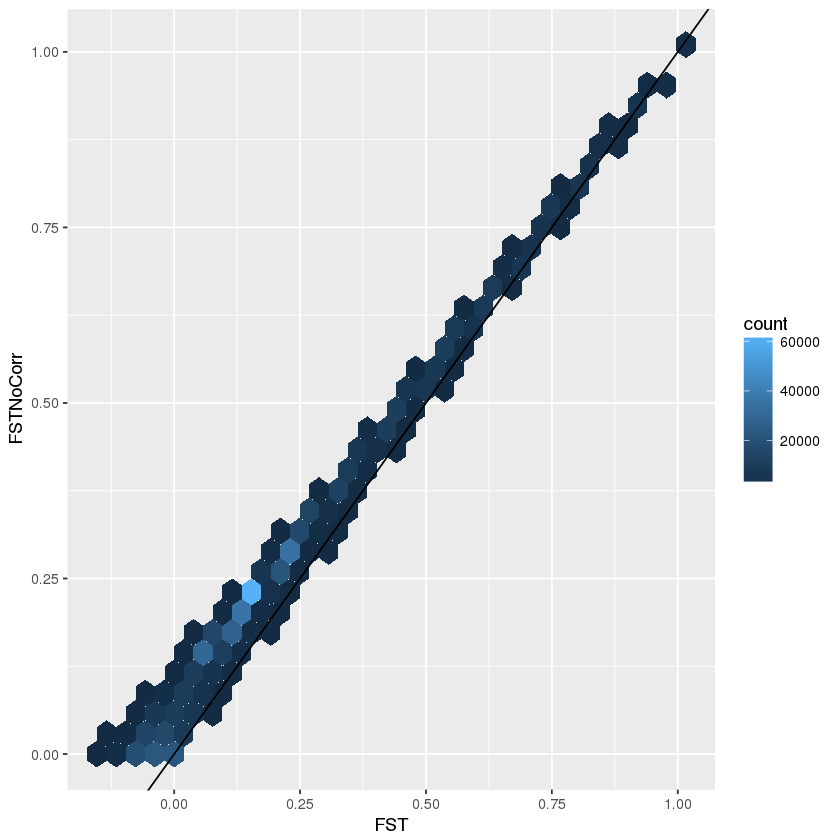

In [20]:
ggplot(vj[["fst"]], aes(FST, FSTNoCorr))+geom_hex()+geom_abline(slope=1, intercept = 0)

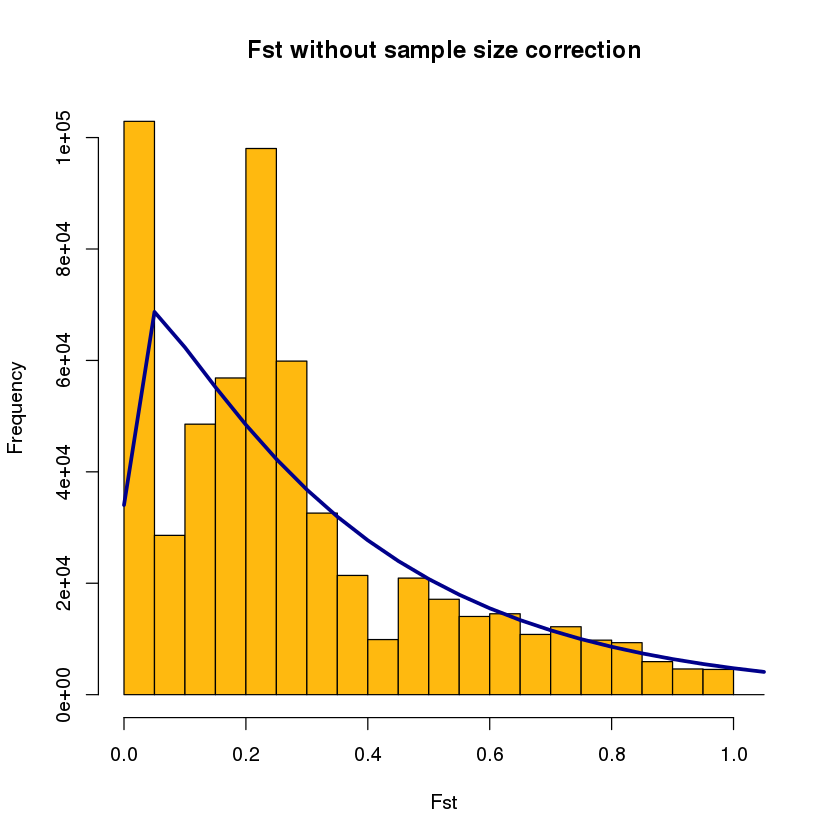

In [21]:
OutFLANKResultsPlotter(vj[["of"]], withOutliers = TRUE, NoCorr = TRUE, Hmin = 0.1, 
                       binwidth = 0.05, Zoom = FALSE, RightZoomFraction = 0.05)

In [120]:
vj[["of"]]$numberHighFstOutliers

[1] 0

### Vd

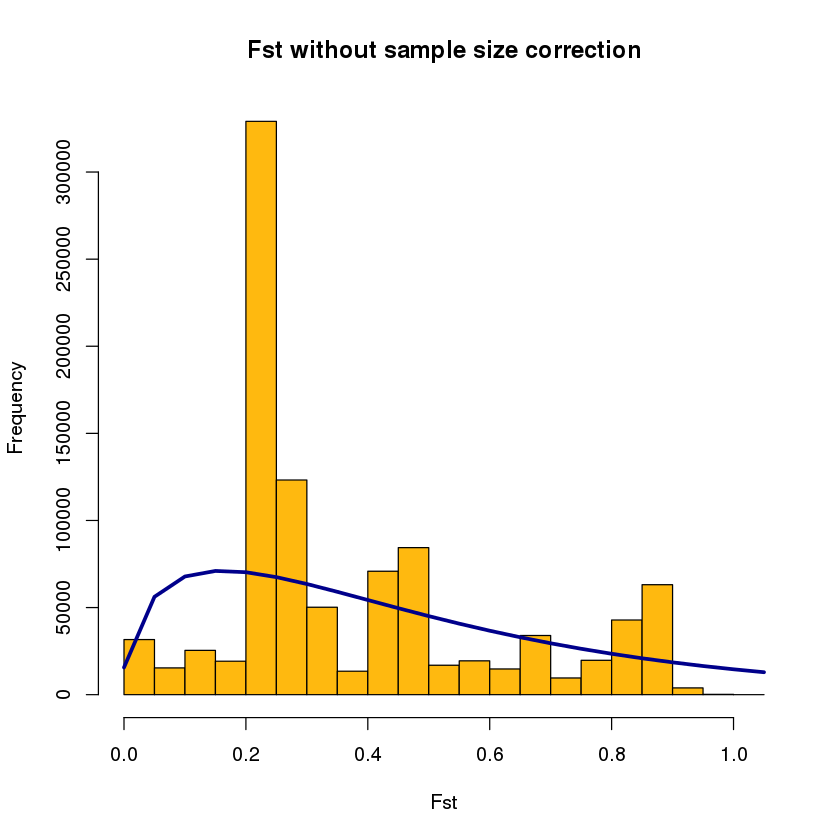

In [23]:
OutFLANKResultsPlotter(vd[["of"]], withOutliers = TRUE, NoCorr = TRUE, Hmin = 0.1, 
                       binwidth = 0.05, Zoom = FALSE, RightZoomFraction = 0.05)

In [119]:
vd[["of"]]$numberHighFstOutliers

[1] 0

OutFlank doesn't help us with either species. It looks like the underlying distribution of Fst values does not fit its model.

## Empirical Fst estimation using VCFlib

In [87]:
vdFst <- read_tsv("../data/R/dFst.txt", col_names = FALSE) %>% 
select(-c(X3,X4)) %>%
rename(chrom = X1, pos = X2, Fst = X5) %>% 
left_join(read_tsv("../data/R/dpFst.txt", col_names = FALSE) %>% 
rename(chrom = X1, pos = X2, p = X3)) %>% 
mutate(qvalue = qvalue(p)$qvalues, siteId = paste(chrom, pos, sep="_"))
table(vdFst$qvalue<0.05)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_integer(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double()
)
Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_integer(),
  X3 = col_double()
)
Joining, by = c("chrom", "pos")



  FALSE    TRUE 
 834622 1115102 

In [81]:
vjFst <- read_tsv("../data/R/jFst.txt", col_names = FALSE) %>% 
select(-c(X3,X4)) %>%
rename(chrom = X1, pos = X2, Fst = X5) %>% 
left_join(read_tsv("../data/R/jpFst.txt", col_names = FALSE) %>% 
rename(chrom = X1, pos = X2, p = X3)) %>% 
mutate(qvalue = qvalue(p)$qvalues, siteId = paste(chrom, pos, sep="_"))
table(vjFst$qvalue<0.05)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_integer(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double()
)
Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_integer(),
  X3 = col_double()
)
Joining, by = c("chrom", "pos")



  FALSE    TRUE 
1485799  213540 

In [92]:
left_join(vjFst, vdFst, by = c("siteId" = "siteId")) %>% na.omit() %>%
summarize(correlation = cor(Fst.x, Fst.y, method = "s"))

correlation
-0.04066887


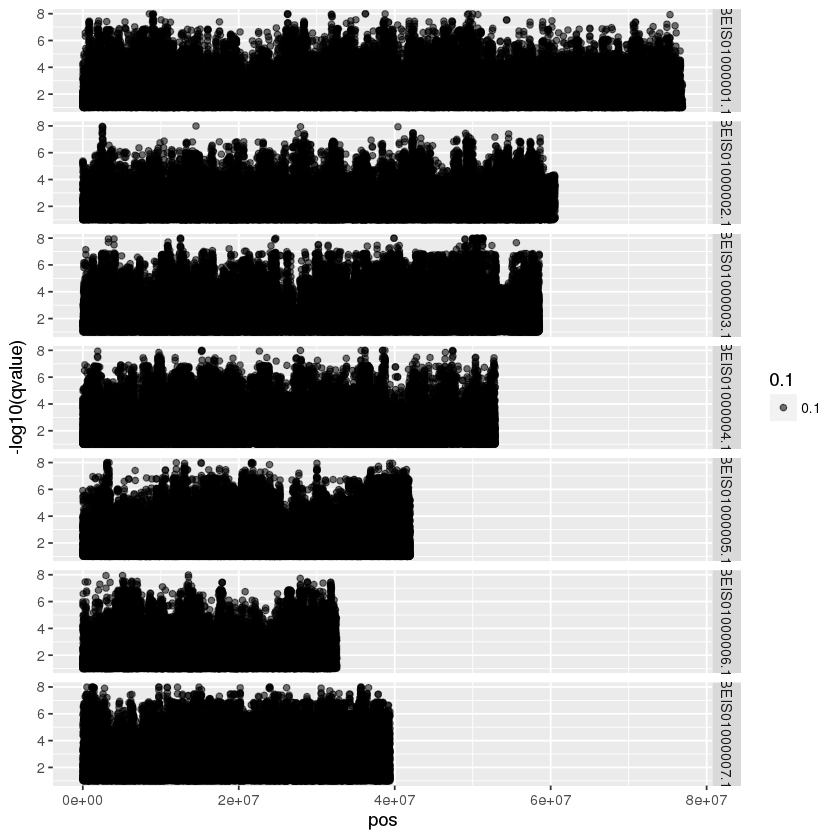

In [100]:
vjFst %>% filter(qvalue < .1) %>% filter(chrom %in% majorLG) %>%
ggplot(aes(pos, -log10(qvalue), alpha = 0.1))+facet_grid(chrom~.)+geom_point()

### Comparing Fst and PCA-based approaches
#### _jacobsoni_

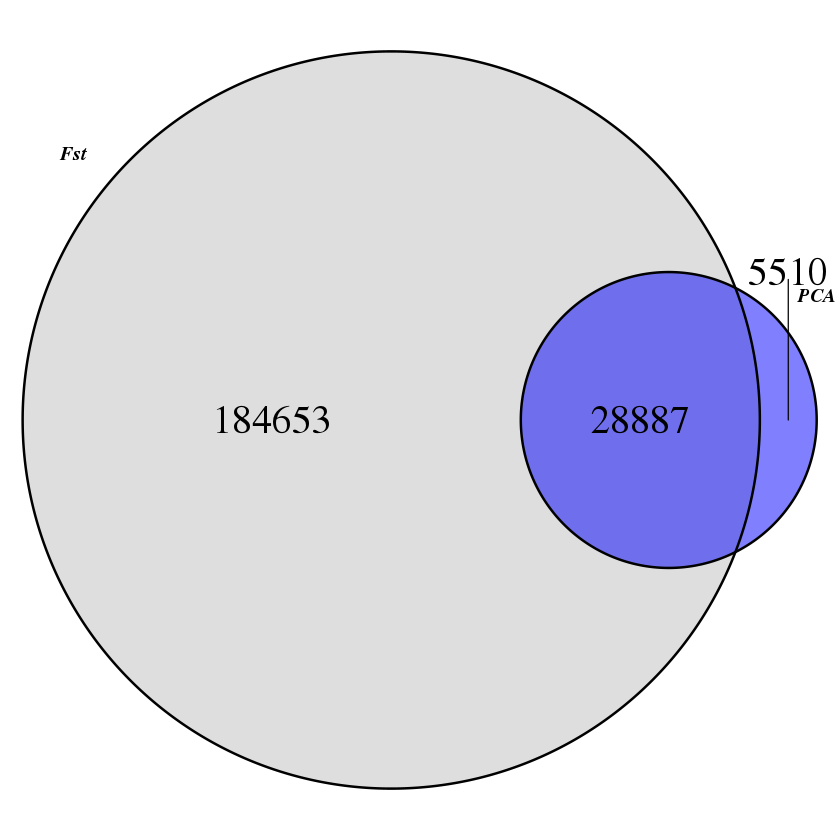

In [115]:
require(VennDiagram)
venn.plot <- 
grid.draw(
    venn.diagram(c(vjFst %>% filter(qvalue < .05) %>% select(siteId),
                  vj.pcadapt %>% filter(qvalue < .05) %>% select(siteId)), 
                 NULL, 
                 fill=c("grey", "blue"), alpha=c(0.5,0.5), 
                 cex = 2, cat.fontface=4, 
                 category.names=c("Fst", "PCA")))

_destructor_

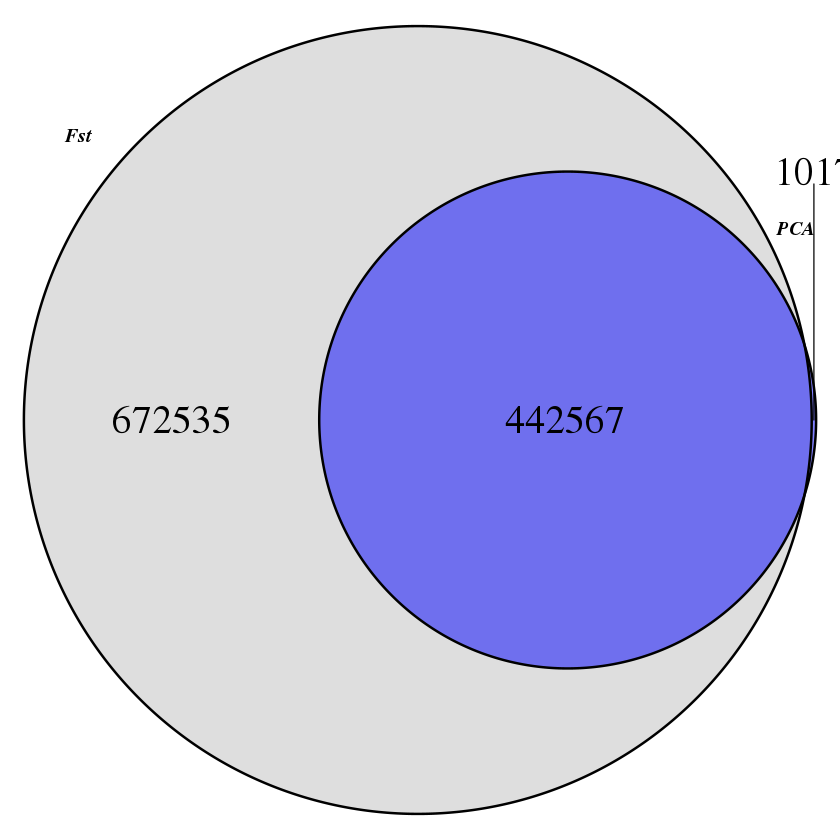

In [114]:
grid.draw(
    venn.diagram(c(vdFst %>% filter(qvalue < .05) %>% select(siteId),
                  vd.pcadapt %>% filter(qvalue < .05) %>% select(siteId)), 
                 NULL, 
                 fill=c("grey", "blue"), alpha=c(0.5,0.5), 
                 cex = 2, cat.fontface=4, 
                 category.names=c("Fst", "PCA")))

There is a lot of concordance between empirical Fst and PCA-based approaches. It looks like the empirical Fst approach is more permissive, and the PCA approach is more conservative. It is probably safest to take the set of overlapping values

`geom_smooth()` using method = 'gam'


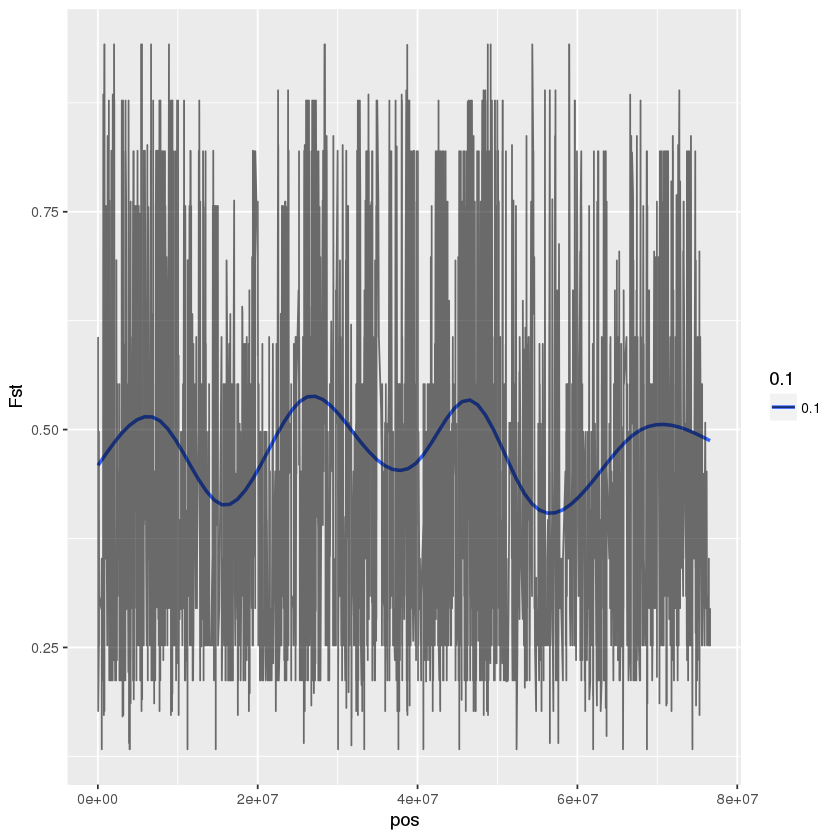

In [151]:
both <- intersect(vjFst %>% filter(qvalue < .05) %>% select(siteId),
                  vj.pcadapt %>% filter(qvalue < .05) 
                              %>% select(siteId))
vjFst %>% mutate(sig = ifelse(siteId %in% both$siteId, "yes", "no")) %>% 
filter(sig == "yes") %>% filter(chrom %in% majorLG[1]) %>%
ggplot(aes(pos, Fst, alpha = 0.1))+geom_smooth(se=F)+geom_line()

In [132]:
table(vjFst$siteId %in% both$siteId)


  FALSE    TRUE 
1670455   28887 

In [141]:
head(vjFst)

chrom,pos,Fst,p,qvalue,siteId
BEIS01000001.1,12810,0.0766529,0.491955,0.2020400,BEIS01000001.1_12810
BEIS01000001.1,13206,-0.0426481,0.866162,0.2801491,BEIS01000001.1_13206
BEIS01000001.1,13209,0.0544495,0.413819,0.1908550,BEIS01000001.1_13209
BEIS01000001.1,13216,-0.0434265,0.982763,0.3050294,BEIS01000001.1_13216
BEIS01000001.1,13219,0.0124688,0.443318,0.1947268,BEIS01000001.1_13219
BEIS01000001.1,13237,-0.0102041,0.574326,0.2170251,BEIS01000001.1_13237
